# Building an Audio Data Model using Chormagram Features

#### Ryan Bales (@ryanbales)<br>ryan@balesofdata.com

***

### Import Packages

In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import BatchNormalization
from keras.layers import LSTM

Using TensorFlow backend.


#### Define Constants

In [2]:
max_feature_length = 128

train_data_path = "data/audio_train/train/"
val_data_path = "data/audio_train/validation/"

model_output_path = "models/chroma/"

### Feature Extraction

#### Let's take a look at the Librosa Python Library

In [3]:
raw_audio, sample_rate = librosa.load("{}Applause/170eeda2.wav".format(train_data_path), sr=None)

In [4]:
raw_audio

array([ 3.0517578e-05,  3.0517578e-05,  3.0517578e-05, ...,
       -6.1035156e-05,  6.1035156e-05, -3.0517578e-05], dtype=float32)

In [5]:
raw_audio.shape

(312228,)

In [6]:
sample_rate

44100

#### Visualize the RAW Audio

Text(0.5, 1.0, 'RAW Audio')

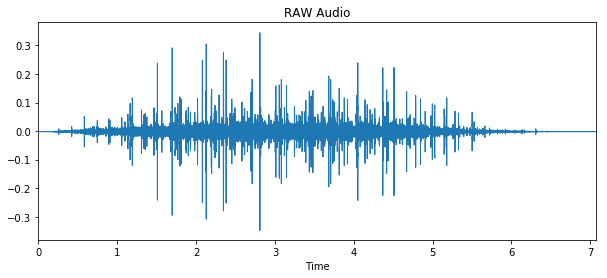

In [7]:
plt.figure(figsize=(10, 4))
librosa.display.waveplot(raw_audio, sr=sample_rate)
plt.title('RAW Audio')

#### Extract the Chromagram using Librosa

In [8]:
chroma = librosa.feature.chroma_stft(y=raw_audio, sr=sample_rate)

In [9]:
chroma

array([[0.45708603, 0.59985061, 0.85535656, ..., 0.53766656, 1.        ,
        0.78869527],
       [0.75006506, 0.74879897, 0.63880852, ..., 0.35619509, 0.80814518,
        0.90725799],
       [1.        , 0.88681515, 0.61255202, ..., 0.44212162, 0.73436712,
        0.97452743],
       ...,
       [0.76023411, 0.83820057, 0.8286142 , ..., 0.42432648, 0.98814941,
        0.9980946 ],
       [0.52218087, 0.59695499, 0.94210506, ..., 0.61444451, 0.90883874,
        1.        ],
       [0.55180056, 0.58229351, 0.95294395, ..., 1.        , 0.88406898,
        0.86646533]])

In [10]:
chroma.shape

(12, 610)

#### Visualize the Chromagam

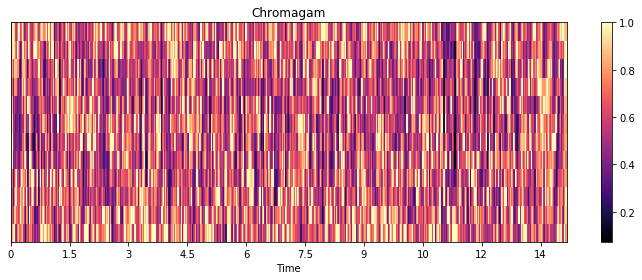

In [11]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, x_axis='time')
plt.colorbar()
plt.title('Chromagam')
plt.tight_layout()

####  Define a Method to Extact the Chromagram from an Audio File

In [12]:
def get_chroma(wav_file, max_length = 128):
    raw_audio, sample_rate = librosa.load(wav_file, sr=None, duration=1)
    chroma = librosa.feature.chroma_stft(y=raw_audio, sr=sample_rate)
    
    # Truncate the Chroma to max_length
    if (max_length > chroma.shape[1]):
        pad_width = max_length - chroma.shape[1]
        chroma = np.pad(chroma, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        chroma = chroma[:, :max_length]
        
    return chroma

#### Process all Files and Extract Features

In [13]:
chroma_list = []
category_list = []

for root, subdirs, files in os.walk(train_data_path):
    subdirs.sort()
    for subdir in subdirs:
        for file_name in os.listdir(os.path.join(root, subdir)):
            if file_name.endswith(".wav"):
                chroma = get_chroma(os.path.join(root, subdir, file_name), max_feature_length)
                chroma_list.append(chroma)
                category_list.append(subdir)

/Users/rbales/.virtualenvs/audio-data-insights/lib/python3.6/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


In [14]:
X_features = np.array(chroma_list)

In [15]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_features = keras.utils.np_utils.to_categorical(le.fit_transform(category_list))

### Save Feature Extraction Results to Disk

Note:  We're saving the extracted features to a file in case we need them later on.  This helps us not have to re-run the Feature Extraction Steps.

In [16]:
np.save("{}features.npy".format(model_output_path), X_features)
np.save("{}labels.npy".format(model_output_path), y_features)
np.save("{}label_encoder.npy".format(model_output_path), le)

### Model Training

In [17]:
model = Sequential()
model.add(BatchNormalization(input_shape=[X_features.shape[1], X_features.shape[2]]))
model.add(LSTM(units=128, dropout=0.05, recurrent_dropout=0.35, return_sequences=True))
model.add(LSTM(units=32, dropout=0.05, recurrent_dropout=0.35, return_sequences=False))
model.add(Dense(len(le.classes_), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['categorical_accuracy'])

model.fit(X_features, y_features, batch_size=16, epochs=50)

Epoch 1/50
2968/2968 [==============================] - 7s 2ms/step - loss: 3.4226 - categorical_accuracy: 0.1055
Epoch 2/50
2968/2968 [==============================] - 5s 2ms/step - loss: 3.1523 - categorical_accuracy: 0.1503
Epoch 3/50
2968/2968 [==============================] - 5s 2ms/step - loss: 3.0226 - categorical_accuracy: 0.1678
Epoch 4/50
2968/2968 [==============================] - 5s 2ms/step - loss: 2.9186 - categorical_accuracy: 0.1698
Epoch 5/50
2968/2968 [==============================] - 5s 2ms/step - loss: 2.7789 - categorical_accuracy: 0.2163
Epoch 6/50
2968/2968 [==============================] - 5s 2ms/step - loss: 2.6949 - categorical_accuracy: 0.2318
Epoch 7/50
2968/2968 [==============================] - 5s 2ms/step - loss: 2.6087 - categorical_accuracy: 0.2591
Epoch 8/50
2968/2968 [==============================] - 5s 2ms/step - loss: 2.5631 - categorical_accuracy: 0.2719
Epoch 9/50
2968/2968 [==============================] - 6s 2ms/step - loss: 2.4750 - cat

### Now that our Model is trained, let's take a look at the Model Layers

In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 12, 128)           512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 128)           131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_1 (Dense)              (None, 41)                1353      
Total params: 154,057
Trainable params: 153,801
Non-trainable params: 256
_________________________________________________________________


### Save the Trained Model to Disk

In [43]:
from keras.models import load_model
model.save("{}model.h5".format(model_output_path))

### Let's Take a Look at How the Model is Performing

In [44]:
chroma = np.array([get_chroma("{}Bass_drum/f78fbf28.wav".format(val_data_path), max_feature_length)])

In [45]:
prediction = model.predict(chroma)
prediction

array([[3.74499905e-05, 2.49708624e-04, 2.85985060e-02, 4.38461676e-02,
        3.97507567e-03, 3.22752458e-04, 4.28946340e-04, 1.70880856e-04,
        1.00219110e-02, 4.56794584e-03, 6.31520711e-03, 2.20371308e-04,
        2.31297709e-05, 2.58389376e-02, 3.21826228e-04, 1.30283624e-01,
        6.93959519e-02, 5.23019815e-03, 1.92271604e-03, 1.44631753e-03,
        2.22594281e-05, 2.07080618e-01, 4.19673670e-05, 2.23067240e-03,
        2.16977540e-02, 3.24318977e-03, 1.26051502e-02, 4.88847531e-02,
        5.21368086e-02, 1.08448425e-02, 3.46357294e-04, 6.52797753e-03,
        1.96367707e-02, 2.74682534e-04, 7.76502490e-03, 6.62474311e-04,
        1.72162727e-01, 5.26656918e-02, 9.89879016e-03, 2.68229214e-03,
        3.53715047e-02]], dtype=float32)

In [46]:
le.classes_[np.argmax(prediction)]

'Gunshot_or_gunfire'

### Let's run Prediction on the files in our Validation DataSet

### Load the Validation Dataset

In [47]:
df_validation = pd.read_csv("data/validation_split.csv")

In [48]:
df_validation["predicted_label"] = ""

In [49]:
print(df_validation.shape)
df_validation.head()

(742, 4)


,fname,manually_verified,label,predicted_label
0,9df6bdd3.wav,1,Glockenspiel,
1,6d3722db.wav,1,Gong,
2,2500d6e9.wav,1,Telephone,
3,5f20684f.wav,1,Cough,
4,b9dd574a.wav,1,Acoustic_guitar,


### Iterate over the Validation Dataset and Run the Model Prediction Step

In [51]:
for index, row in df_validation.iterrows():
    val_file_path = "{}{}/{}".format(val_data_path, row['label'], row['fname'])
  
    chroma = np.array([get_chroma(val_file_path, max_feature_length)])
    prediction = model.predict(chroma)
    predicted_label = le.classes_[np.argmax(prediction)]

    df_validation.at[index,'predicted_label'] = predicted_label

In [52]:
df_validation.head()

,fname,manually_verified,label,predicted_label
0,9df6bdd3.wav,1,Glockenspiel,Glockenspiel
1,6d3722db.wav,1,Gong,Cello
2,2500d6e9.wav,1,Telephone,Violin_or_fiddle
3,5f20684f.wav,1,Cough,Drawer_open_or_close
4,b9dd574a.wav,1,Acoustic_guitar,Acoustic_guitar


### Let's Review our F1 Score per Category

In [53]:
y_val = df_validation.label
y_val_predicted = df_validation.predicted_label

# Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_predicted))

                       precision    recall  f1-score   support

      Acoustic_guitar       0.45      0.43      0.44        21
             Applause       0.23      0.25      0.24        12
                 Bark       0.25      0.23      0.24        13
            Bass_drum       0.53      0.62      0.57        13
Burping_or_eructation       0.27      0.27      0.27        15
                  Bus       0.09      0.08      0.09        12
                Cello       0.39      0.36      0.37        25
                Chime       0.20      0.23      0.21        13
             Clarinet       0.30      0.23      0.26        26
    Computer_keyboard       0.00      0.00      0.00        12
                Cough       0.22      0.14      0.17        14
              Cowbell       0.77      0.89      0.83        19
          Double_bass       0.29      0.32      0.30        19
 Drawer_open_or_close       0.00      0.00      0.00        13
       Electric_piano       0.11      0.07      0.08  